# Exploración y limpieza del Dataset
---

En este primer cuaderno, cargaremos el dataset recopilado con el código automatizado para la descarga, haremos un analisis exploratorio y dejaremos listos los datos para pasarlos al modelo de ML.

## **1. Carga de Datos**
---

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargamos los datos
file_path = '../../Dengue_consolidado_distrital_final.csv'

try:
    df = pd.read_csv(file_path)
    print("Archivo cargado exitosamente.")
    print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.") #Info de cada columna
    print("\nInformación del DataFrame:")
    df.info()
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta '{file_path}'")
    print("Por favor, asegúrate de que la ruta sea correcta desde la ubicación de tu notebook.")

C:\Users\leoni\AppData\Local\Temp\ipykernel_7908\1561272159.py:10: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Archivo cargado exitosamente.
El dataset tiene 908980 filas y 19 columnas.

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908980 entries, 0 to 908979
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Departamento    908980 non-null  object 
 1   Provincia       908980 non-null  object 
 2   Distrito        908980 non-null  object 
 3   UBIGEO          908980 non-null  int64  
 4   tmean           865791 non-null  float64
 5   tmax            865791 non-null  float64
 6   tmin            865791 non-null  float64
 7   humr            865791 non-null  float64
 8   ptot            876102 non-null  float64
 9   Ano             908980 non-null  int64  
 10  Semana          908980 non-null  int64  
 11  tmean_clima     898170 non-null  float64
 12  tmax_clima      898170 non-null  float64
 13  tmin_clima      898170 non-null  float64
 14  humr_clima      898170 non-null  float64
 15 

## **2. Primera limpieza de datos**
---
A partir de la carga del dataset, vemos idnicialmente que hay Datos Faltantes en Casos:
*   Departamento: 908,980 filas con datos.
*   Casos: solo 60,205 filas con datos.

Esto significa que la gran mayoría de filas no tienen un valor en la columna Casos. Lo más probable es que estas filas representen semanas en las que no se reportaron casos, y por eso el valor es NaN (nulo). Para tener adecuadamente el dataset los reemplazaremos explicitamente por 0.
Adicionalmente. vemos que hay columnas que para este momento puede que no nos aporten mucha información, como el tipo de casos (que si sería importante analizarlo más adelante), nos quedaremos solo con total porque fueron los que descargamos, y eliminamos la data de archivo de procedencia que fue cuando creamos el dataset.
La siguiente celda de código:
* Rellenará los Casos nulos con 0.
* Eliminará las columnas que no necesitamos.
* Rellenará los pequeños huecos en los datos climáticos.
* Creará una verdadera columna de fecha a partir de Ano y Semana para poder hacer análisis de series temporales.

In [7]:
# Hacemos una copia para mantener el dataframe original intacto
df_clean = df.copy()

# 1. Limpieza de Casos y Columnas Innecesarias
# Rellenamos los valores nulos en 'Casos' con 0, ya que NaN.
df_clean['Casos'] = df_clean['Casos'].fillna(0)

# Convertimos la columna 'Casos' a tipo entero, ya que son conteos.
df_clean['Casos'] = df_clean['Casos'].astype(int)

# Eliminamos las columnas que no son útiles para el modelo.
# 'Tipo caso' está casi vacía y 'origen_archivo' es metadatos.
df_clean = df_clean.drop(columns=['Tipo caso', 'origen_archivo'])

print("Paso 1: Limpieza de 'Casos' y columnas innecesarias completado.")

# 2. Manejo de Nulos en Variables Climáticas
# Agrupamos por distrito (UBIGEO) y rellenamos los nulos usando el último valor válido (forward fill).
# Esto previene que datos de un distrito se filtren a otro.
climate_cols = ['tmean', 'tmax', 'tmin', 'humr', 'ptot', 'tmean_clima', 'tmax_clima', 'tmin_clima', 'humr_clima']
df_clean[climate_cols] = df_clean.groupby('UBIGEO')[climate_cols].transform(lambda x: x.ffill().bfill())

print("Paso 2: Imputación de datos climáticos completado.")

# 3. Creación y Configuración del Índice Temporal
# Creamos una columna 'Fecha' combinando año y semana.
# El formato '%Y-W%W-%w' se traduce a 'Año-Semana-DíaDeLaSemana'. Usamos el día 1 (Lunes).
df_clean['Fecha'] = pd.to_datetime(df_clean['Ano'].astype(str) + '-W' + df_clean['Semana'].astype(str) + '-1', format='%Y-W%W-%w')

# Establecemos la nueva columna 'Fecha' como el índice del DataFrame.
df_clean = df_clean.set_index('Fecha')

# Ordenamos el DataFrame por el índice para asegurar el orden cronológico.
df_clean = df_clean.sort_index()

print("Paso 3: Creación y configuración del índice temporal completado.")

# Verificación Final
print("\nVerificación final del DataFrame limpio:")
df_clean.info()

print("\nPrimeras 5 filas del DataFrame limpio:")
print(df_clean.head())

Paso 1: Limpieza de 'Casos' y columnas innecesarias completado.
Paso 2: Imputación de datos climáticos completado.
Paso 3: Creación y configuración del índice temporal completado.

Verificación final del DataFrame limpio:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 908980 entries, 2017-01-02 to 2026-01-05
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Departamento  908980 non-null  object 
 1   Provincia     908980 non-null  object 
 2   Distrito      908980 non-null  object 
 3   UBIGEO        908980 non-null  int64  
 4   tmean         899580 non-null  float64
 5   tmax          899580 non-null  float64
 6   tmin          899580 non-null  float64
 7   humr          899580 non-null  float64
 8   ptot          908980 non-null  float64
 9   Ano           908980 non-null  int64  
 10  Semana        908980 non-null  int64  
 11  tmean_clima   898170 non-null  float64
 12  tmax_clima    898170 non-null 

Notamos que algunas columnas climáticas (tmean, tmax_clima, etc.) todavía tienen algunos valores nulos, incluso después de nuestro primer intento de imputación. Esto puede suceder si un distrito entero no tiene datos al principio o al final de su serie temporal.
Vamos a solucionarlo definitivamente con una imputación final más simple, rellenando cualquier hueco restante con la media de su respectiva columna.

Imputación final completada. Verificando nulos restantes:
Departamento    0
Provincia       0
Distrito        0
UBIGEO          0
tmean           0
tmax            0
tmin            0
humr            0
ptot            0
Ano             0
Semana          0
tmean_clima     0
tmax_clima      0
tmin_clima      0
humr_clima      0
ptot_clima      0
Casos           0
dtype: int64


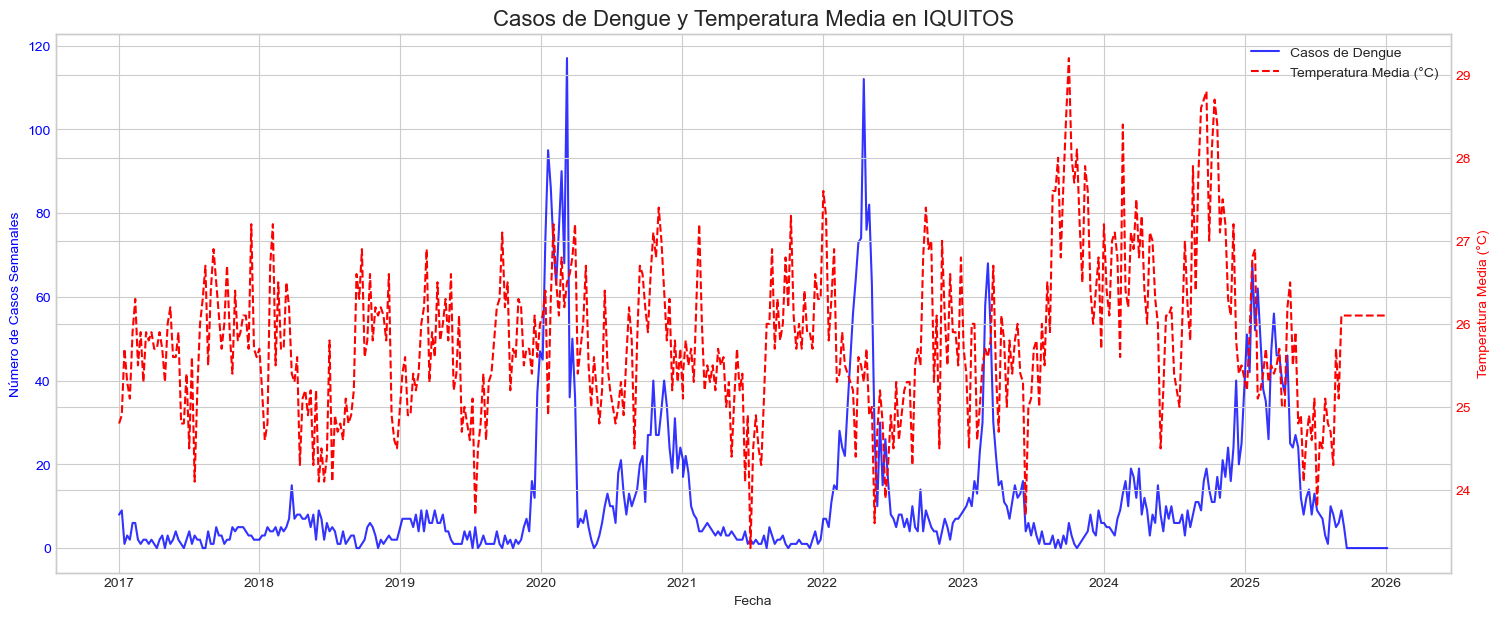

In [8]:
# 1. Imputación Final para Nulos Restantes ---
# Rellenamos cualquier valor nulo que haya quedado con la media de su columna.
# Esto es seguro ahora que la mayoría de los huecos se han llenado contextualmente.
df_clean = df_clean.fillna(df_clean.mean(numeric_only=True))

print("Imputación final completada. Verificando nulos restantes:")
print(df_clean.isnull().sum())


# 2. Visualización de la Serie Temporal de un Distrito
# Vamos a analizar un distrito conocido por su alta incidencia de dengue.
# Por ejemplo en este caso haremos para IQUITOS
# Filtramos el DataFrame para obtener solo los datos del distrito de IQUITOS.

try:
    distrito_a_visualizar = 'IQUITOS'
    df_distrito = df_clean[df_clean['Distrito'] == distrito_a_visualizar]

    if df_distrito.empty:
        print(f"\nAdvertencia: No se encontraron datos para el distrito '{distrito_a_visualizar}'.")
        print("Mostrando datos del primer distrito disponible en el dataset.")
        primer_ubigeo = df_clean['UBIGEO'].iloc[0]
        df_distrito = df_clean[df_clean['UBIGEO'] == primer_ubigeo]
        distrito_a_visualizar = df_distrito['Distrito'].iloc[0]

    # Creación del Gráfico
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(18, 7))

    # Eje 1 (Izquierda) para los Casos de Dengue
    ax1.plot(df_distrito.index, df_distrito['Casos'], color='blue', label='Casos de Dengue', alpha=0.8)
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Número de Casos Semanales', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title(f'Casos de Dengue y Temperatura Media en {distrito_a_visualizar.upper()}', fontsize=16)

    # Eje 2 (Derecha) para la Temperatura
    ax2 = ax1.twinx()
    ax2.plot(df_distrito.index, df_distrito['tmean'], color='red', linestyle='--', label='Temperatura Media (°C)')
    ax2.set_ylabel('Temperatura Media (°C)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Añadir leyendas
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.show()

except Exception as e:
    print(f"\nOcurrió un error al intentar graficar: {e}")
    print("Esto puede suceder si el distrito seleccionado no tiene datos suficientes.")

---

### **Análisis Cuantitativo de Retraso (Cross-Correlation)**

El gráfico anterior de Iquitos nos da una pista visual muy fuerte: los picos de **casos de dengue (azul)** parecen ocurrir *después* de los picos de **temperatura (rojo)**. Esto sugiere que las condiciones climáticas de hoy no afectan los casos de dengue de hoy, sino los del futuro. El ciclo de vida del mosquito *Aedes aegypti* (huevo -> larva -> pupa -> adulto) y el período de incubación del virus dependen directamente de la temperatura, la humedad y la lluvia.

Nuestro objetivo ahora es cuantificar exactamente este desfase o **"lag"**. Queremos responder a la pregunta: ¿La temperatura de hace cuántas semanas tiene el mayor impacto en los casos de dengue de esta semana? ¿Y la humedad? ¿Y la precipitación?

Para ello, utilizaremos una técnica llamada **análisis de correlación cruzada**. Calcularemos la correlación entre la serie de `Casos` y las series climáticas desplazadas en el tiempo (1 semana atrás, 2 semanas atrás, etc.). El desplazamiento que muestre la correlación más alta será el "lag" óptimo para esa variable.

Este análisis es el paso más crucial para la **ingeniería de características**, ya que nos dirá qué variables retrasadas debemos crear para alimentar nuestro modelo de Machine Learning.

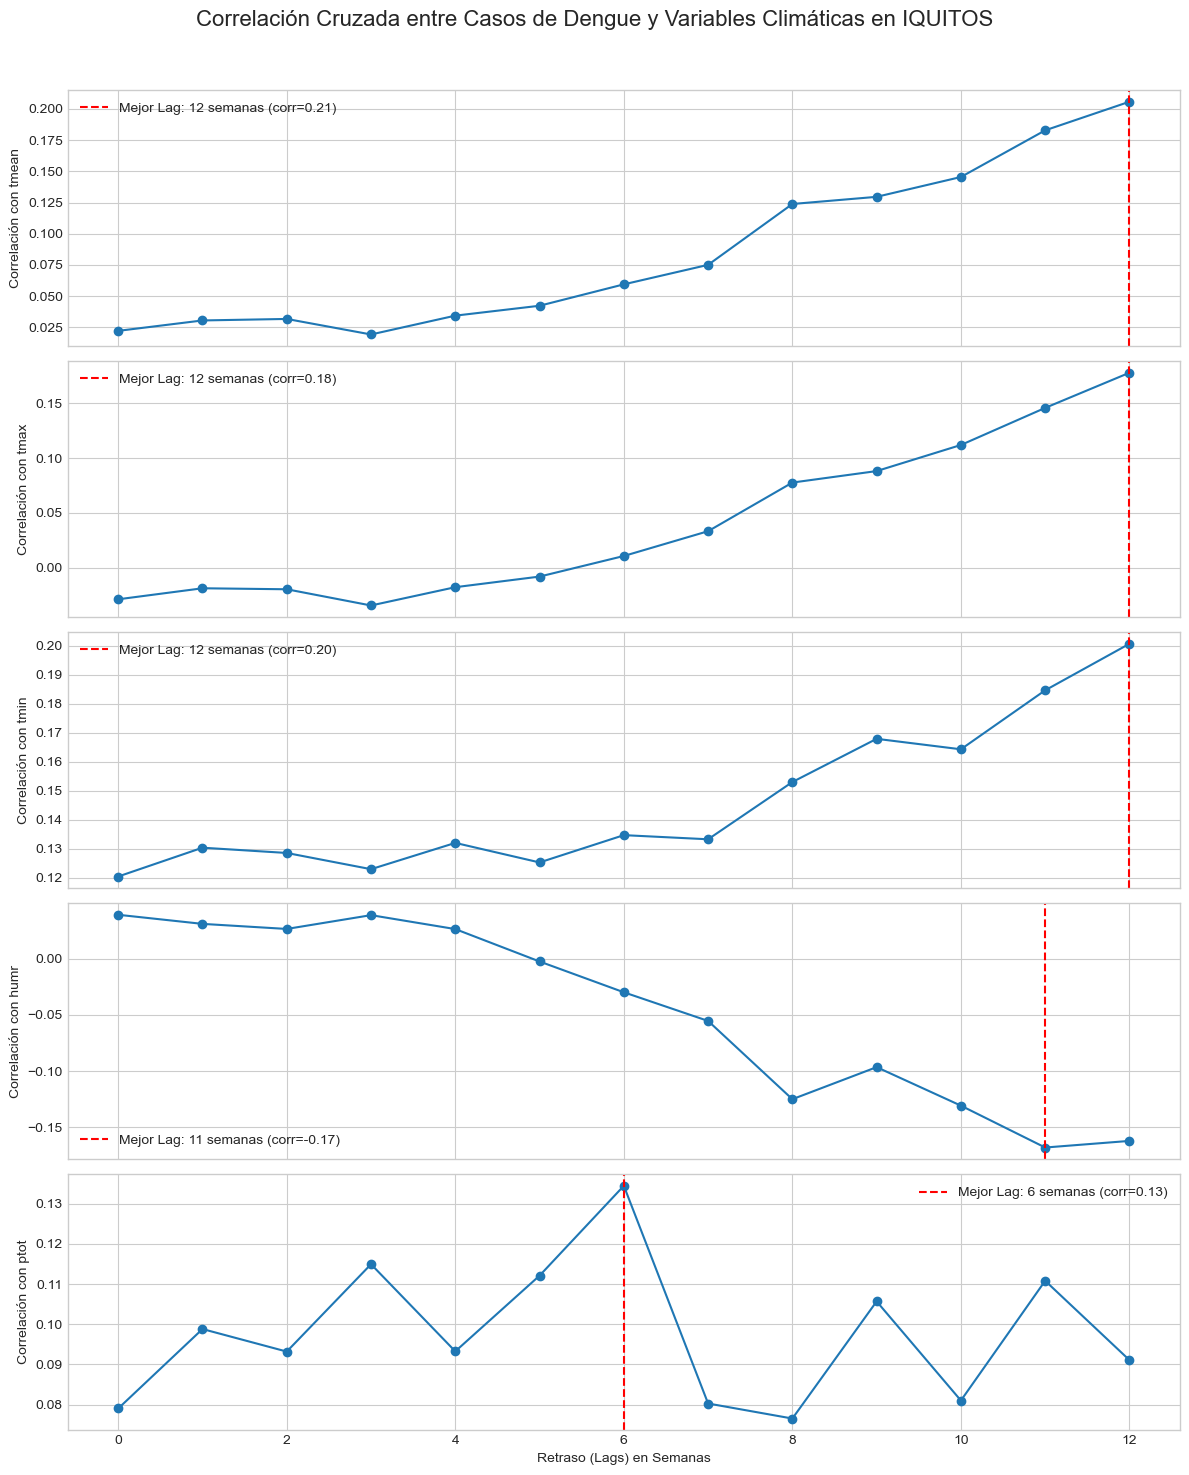

Resumen de los Lags con Mayor Correlación:
- Para la variable 'tmean', el retraso óptimo es de 12 semanas.
- Para la variable 'tmax', el retraso óptimo es de 12 semanas.
- Para la variable 'tmin', el retraso óptimo es de 12 semanas.
- Para la variable 'humr', el retraso óptimo es de 11 semanas.
- Para la variable 'ptot', el retraso óptimo es de 6 semanas.


In [9]:
# Análisis de Correlación Cruzada 
# Nos aseguramos de seguir usando el DataFrame del distrito que ya filtramos.
# Si df_distrito no existe, se vuelve a filtrar por seguridad.
if 'df_distrito' not in locals() or df_distrito.empty:
    distrito_a_analizar = 'IQUITOS'
    df_distrito = df_clean[df_clean['Distrito'] == distrito_a_analizar].copy()

# Variables climáticas que queremos analizar
variables_climaticas = ['tmean', 'tmax', 'tmin', 'humr', 'ptot']
target_variable = 'Casos'

# Definimos el número máximo de semanas de retraso a probar
max_lag = 12
lags = range(0, max_lag + 1)

# Creamos un diccionario para guardar los resultados de correlación
correlations = {var: [] for var in variables_climaticas}

# Calculamos la correlación para cada variable y cada lag
for var in variables_climaticas:
    for lag in lags:
        # Creamos una versión retrasada de la variable climática
        shifted_series = df_distrito[var].shift(lag)
        # Calculamos la correlación y la guardamos
        corr = df_distrito[target_variable].corr(shifted_series)
        correlations[var].append(corr)

# Visualización de los Resultados
fig, axes = plt.subplots(nrows=len(variables_climaticas), ncols=1, figsize=(12, 15), sharex=True)
fig.suptitle(f'Correlación Cruzada entre Casos de Dengue y Variables Climáticas en {distrito_a_visualizar.upper()}', fontsize=16)

for i, var in enumerate(variables_climaticas):
    ax = axes[i]
    ax.plot(lags, correlations[var], marker='o', linestyle='-')
    
    # Encontramos y marcamos el lag con la correlación máxima
    best_lag = np.argmax(np.abs(correlations[var]))
    best_corr = correlations[var][best_lag]
    ax.axvline(best_lag, color='r', linestyle='--', label=f'Mejor Lag: {best_lag} semanas (corr={best_corr:.2f})')
    
    ax.set_ylabel(f'Correlación con {var}')
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Retraso (Lags) en Semanas')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Imprimir el resumen de los mejores lags
print("Resumen de los Lags con Mayor Correlación:")
for var in variables_climaticas:
    best_lag = np.argmax(np.abs(correlations[var]))
    print(f"- Para la variable '{var}', el retraso óptimo es de {best_lag} semanas.")

### **Refinamiento del Análisis de Retraso**

Cuando el retraso óptimo para una variable coincide con el máximo que hemos definido (`max_lag = 12`), es muy probable que el verdadero pico de correlación se encuentre más allá de nuestra ventana de búsqueda. Para estar seguros de haber encontrado el verdadero punto de máxima influencia, debemos ampliar nuestro horizonte.

Biológicamente tiene sentido. Un cambio en la temperatura puede tardar varios meses en traducirse en un brote significativo: afecta la velocidad de eclosión de los huevos, el desarrollo de las larvas, la tasa de picadura del mosquito adulto y el período de incubación del virus dentro del mosquito. Un proceso que puede durar más de 3 meses (12 semanas).

Vamos a re-ejecutar el análisis, pero esta vez ampliando la búsqueda hasta **20 semanas** (aproximadamente 5 meses). Este rango es lo suficientemente amplio como para capturar la mayoría de los procesos biológicos relevantes sin introducir demasiado ruido.


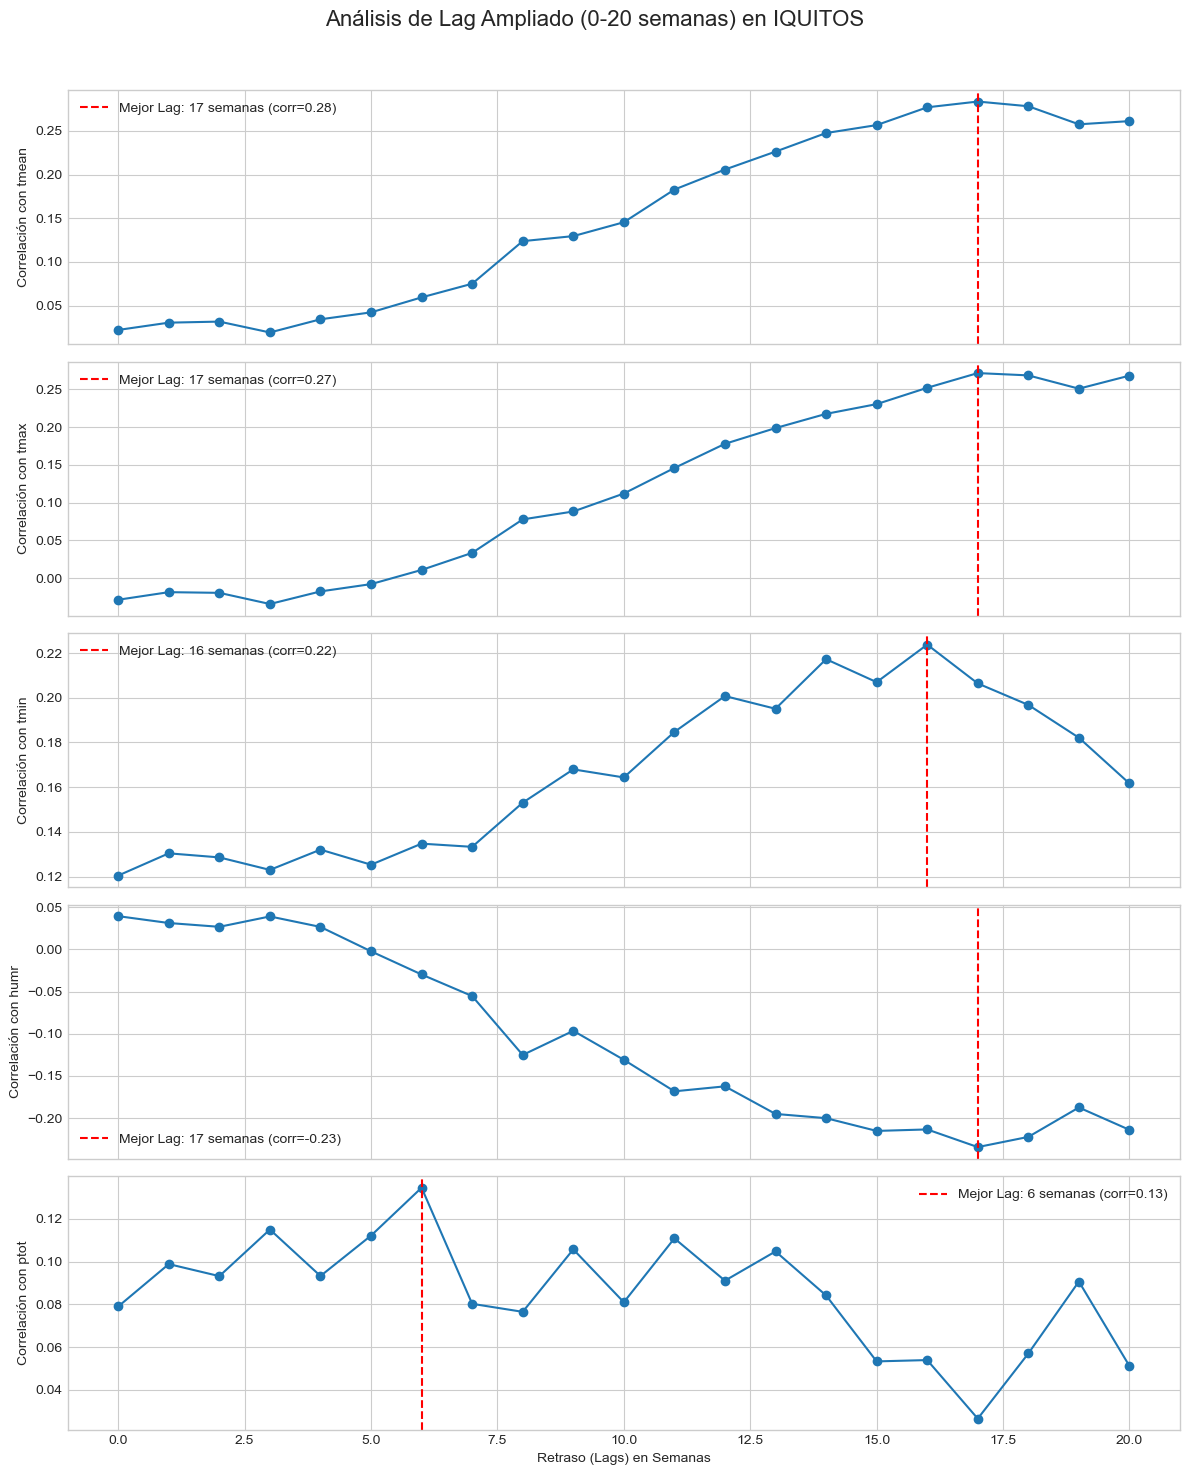

Resumen de los Lags con Mayor Correlación (Análisis Ampliado):
- Para la variable 'tmean', el retraso óptimo es de 17 semanas.
- Para la variable 'tmax', el retraso óptimo es de 17 semanas.
- Para la variable 'tmin', el retraso óptimo es de 16 semanas.
- Para la variable 'humr', el retraso óptimo es de 17 semanas.
- Para la variable 'ptot', el retraso óptimo es de 6 semanas.


In [10]:
# Refinamiento del Análisis de Correlación Cruzada

# Variables climáticas que queremos analizar
variables_climaticas = ['tmean', 'tmax', 'tmin', 'humr', 'ptot']
target_variable = 'Casos'

# CAMBIO PRINCIPAL: Ampliamos el rango de búsqueda a 20 semanas.
max_lag_ampliado = 20
lags_ampliado = range(0, max_lag_ampliado + 1)

# Creamos un nuevo diccionario para los resultados
correlations_ampliado = {var: [] for var in variables_climaticas}

# Re-calculamos la correlación para cada variable con el nuevo rango de lags
for var in variables_climaticas:
    for lag in lags_ampliado:
        shifted_series = df_distrito[var].shift(lag)
        corr = df_distrito[target_variable].corr(shifted_series)
        correlations_ampliado[var].append(corr)

# Visualización de los Nuevos Resultados
fig, axes = plt.subplots(nrows=len(variables_climaticas), ncols=1, figsize=(12, 15), sharex=True)
fig.suptitle(f'Análisis de Lag Ampliado (0-20 semanas) en {distrito_a_visualizar.upper()}', fontsize=16)

for i, var in enumerate(variables_climaticas):
    ax = axes[i]
    ax.plot(lags_ampliado, correlations_ampliado[var], marker='o', linestyle='-')
    
    # Encontramos y marcamos el nuevo lag con la correlación máxima
    best_lag = np.argmax(np.abs(correlations_ampliado[var]))
    best_corr = correlations_ampliado[var][best_lag]
    ax.axvline(best_lag, color='r', linestyle='--', label=f'Mejor Lag: {best_lag} semanas (corr={best_corr:.2f})')
    
    ax.set_ylabel(f'Correlación con {var}')
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Retraso (Lags) en Semanas')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Imprimir el resumen de los mejores lags del análisis ampliado
print("Resumen de los Lags con Mayor Correlación (Análisis Ampliado):")
for var in variables_climaticas:
    best_lag = np.argmax(np.abs(correlations_ampliado[var]))
    print(f"- Para la variable '{var}', el retraso óptimo es de {best_lag} semanas.")

### Descubrimiento de Lags a Nivel Departamental

Ya vimos, que podemos obtener un estimado de retrasos para IQUITOS, ahora si bien lo optimo podría ser hacer el análisis para cada distrito, esto podría recaer en artefactos por el ruido o en los casos en los que no haya registro por semanas, hacer interpretaciones errones u overfittings, para evitar esto es que haremos el análisis de correlación a nivel departamental.

En esta celda, vamos a crear una función que realice el análisis de correlación cruzada y la usaremos para iterar sobre cada departamento. Almacenaremos los lags óptimos para cada uno en un DataFrame, lo que nos permitirá inspeccionar y utilizar estos patrones departamentales.

In [11]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Descubrimiento de Lags a Nivel Departamental
print("Iniciando el descubrimiento de lags óptimos por departamento...")

# Lista de departamentos únicos en el dataset
departamentos = df_clean['Departamento'].unique()

# Variables a analizar
variables_climaticas = ['tmean', 'tmax', 'tmin', 'humr', 'ptot']
target_variable = 'Casos'
max_lag = 20
lags = range(0, max_lag + 1)

# DataFrame para almacenar los lags óptimos de cada departamento
lags_departamentales = pd.DataFrame(index=departamentos, columns=variables_climaticas)

# Iteramos sobre cada departamento
for depto in departamentos:
    # Agrupamos todos los datos del departamento y sumamos los casos por semana
    df_depto = df_clean[df_clean['Departamento'] == depto].copy()
    
    # Para tener una serie temporal robusta, agrupamos por fecha y calculamos la media climática y la suma de casos
    serie_depto = df_depto.groupby(df_depto.index).agg({
        'Casos': 'sum',
        'tmean': 'mean',
        'tmax': 'mean',
        'tmin': 'mean',
        'humr': 'mean',
        'ptot': 'mean'
    }).dropna()

    if serie_depto.empty or serie_depto['Casos'].sum() == 0:
        print(f"-> Departamento '{depto}' no tiene suficientes datos de casos. Se omitirá.")
        continue

    # Calculamos el lag óptimo para cada variable climática en este departamento
    for var in variables_climaticas:
        correlations = [serie_depto[target_variable].corr(serie_depto[var].shift(lag)) for lag in lags]
        best_lag = np.argmax(np.abs(correlations))
        lags_departamentales.loc[depto, var] = best_lag

    print(f"-> Lags calculados para el departamento: {depto}")

# Limpiamos el resultado de departamentos sin datos
lags_departamentales.dropna(inplace=True)

# Mostramos la tabla de lags óptimos por departamento
print("\n--- Tabla de Lags Óptimos por Departamento (en semanas) ---")
print(lags_departamentales)

# Guardamos esta tabla para referencia futura
lags_path = 'lags_optimos_por_departamento.csv'
lags_departamentales.to_csv(lags_path)
print(f"\nTabla de lags guardada en: '{lags_path}'")

Iniciando el descubrimiento de lags óptimos por departamento...
-> Lags calculados para el departamento: AMAZONAS
-> Lags calculados para el departamento: LIMA METROPOLITANA
-> Lags calculados para el departamento: TUMBES
-> Lags calculados para el departamento: MOQUEGUA
-> Lags calculados para el departamento: MADRE DE DIOS
-> Lags calculados para el departamento: SAN MARTIN
-> Lags calculados para el departamento: CUSCO
-> Lags calculados para el departamento: CALLAO
-> Lags calculados para el departamento: JUNIN
-> Lags calculados para el departamento: PIURA
-> Lags calculados para el departamento: UCAYALI
-> Lags calculados para el departamento: ANCASH
-> Lags calculados para el departamento: APURIMAC
-> Departamento 'TACNA' no tiene suficientes datos de casos. Se omitirá.
-> Lags calculados para el departamento: ICA
-> Lags calculados para el departamento: LAMBAYEQUE
-> Lags calculados para el departamento: AYACUCHO
-> Lags calculados para el departamento: LIMA
-> Lags calculados 

### **Feature Engineering**
El último paso en este notebook es crear un nuevo DataFrame que contenga estas nuevas características "retrasadas". Además de las variables climáticas, añadiremos también características autorregresivas, es decir, el número de casos en semanas anteriores (Casos_lag_1, Casos_lag_2, etc.). El estado actual de una epidemia es un predictor muy fuerte de su estado en el futuro inmediato.

Ahora, usaremos la tabla lags_departamentales que acabamos de crear para construir las características de manera dinámica. Para cada fila de nuestro dataset, miraremos a qué departamento pertenece, consultaremos el lag óptimo para esa variable en ese departamento y crearemos la característica correspondiente.

In [12]:
# Feature engineering con Lags Departamentales
print("\nIniciando la creación de características con lags departamentales...")

df_features = df_clean.copy()

# Creamos las columnas para los lags, inicialmente vacías
for var in variables_climaticas:
    df_features[f'{var}_lag_depto'] = np.nan

# Agregamos también los lags autorregresivos (estos son siempre iguales)
autoregressive_lags = [1, 2, 3, 4]
for lag_value in autoregressive_lags:
    df_features[f'Casos_lag{lag_value}'] = df_features.groupby('UBIGEO')['Casos'].shift(lag_value)

# Iteramos por cada departamento para aplicar sus lags específicos
for depto in lags_departamentales.index:
    print(f"-> Aplicando lags para: {depto}")
    
    # Seleccionamos los datos de este departamento
    mask_depto = df_features['Departamento'] == depto
    
    # Para cada variable, aplicamos el lag correspondiente de nuestra tabla
    for var in variables_climaticas:
        lag = lags_departamentales.loc[depto, var]
        # Agrupamos por distrito (UBIGEO) para aplicar el shift correctamente
        shifted_values = df_features[mask_depto].groupby('UBIGEO')[var].shift(lag)
        df_features.loc[mask_depto, f'{var}_lag_depto'] = shifted_values

print("\nCreación de características con lags departamentales completada.")

# Limpieza Final y Guardado
df_model = df_features.dropna()
print(f"Se eliminaron las filas iniciales con valores nulos. El nuevo dataset tiene {df_model.shape[0]} filas.")

output_path = 'Dengue_procesado_para_modelo_lags_depto.csv'
df_model.to_csv(output_path)

print(f"\n¡Proceso completado!")
print(f"El DataFrame final con lags departamentales ha sido guardado en: '{output_path}'")
print("\nPrimeras filas del DataFrame listo para el modelo:")
print(df_model.head())


Iniciando la creación de características con lags departamentales...
-> Aplicando lags para: AMAZONAS
-> Aplicando lags para: LIMA METROPOLITANA
-> Aplicando lags para: TUMBES
-> Aplicando lags para: MOQUEGUA
-> Aplicando lags para: MADRE DE DIOS
-> Aplicando lags para: SAN MARTIN
-> Aplicando lags para: CUSCO
-> Aplicando lags para: CALLAO
-> Aplicando lags para: JUNIN
-> Aplicando lags para: PIURA
-> Aplicando lags para: UCAYALI
-> Aplicando lags para: ANCASH
-> Aplicando lags para: APURIMAC
-> Aplicando lags para: ICA
-> Aplicando lags para: LAMBAYEQUE
-> Aplicando lags para: AYACUCHO
-> Aplicando lags para: LIMA
-> Aplicando lags para: PASCO
-> Aplicando lags para: LA LIBERTAD
-> Aplicando lags para: HUANUCO
-> Aplicando lags para: CAJAMARCA
-> Aplicando lags para: LORETO
-> Aplicando lags para: PUNO
-> Aplicando lags para: AREQUIPA

Creación de características con lags departamentales completada.
Se eliminaron las filas iniciales con valores nulos. El nuevo dataset tiene 817487 f